In [60]:
%matplotlib inline

import matplotlib.pyplot as plt

import pickle
import shutil
import sys
import time

# NumPy and TensorFlow
import numpy as np
import pandas as pd
import tensorflow as tf


import nltk
nltk.download("punkt")

sys.path.append("..")
# from features import common
from IPython.display import Image, HTML

[nltk_data] Downloading package punkt to /Users/koza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
print "Loading dataset..."
with open("/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/data/ka-rank-balanced.pickle", "rb") as f:
    comments_dataset = pickle.load(f)    
print "Done."

Loading dataset...
Done.


In [62]:
comments_dataset.keys()

['test_data', 'validate_data', 'train_data']

In [63]:
# How many words in the longest post?
cont = comments_dataset['train_data']['content']
print max([len(x.split(" ")) for x in cont])
max_cont = comments_dataset['train_data'].iloc[max([len(x.split(" ")) for x in cont])]['content']

3439


In [113]:
test_data = comments_dataset['test_data']

In [114]:
test_data.head()


,video,id,content,authorKaid,answerCount,replyCount,date,sumVotesIncremented,qualityKind,replyTo,hasVotes,daysAgo,totalComments,relRank,topRank,bottomRank,label
359672,galactic-collisions,69a126366de0c011d71c16ae9c5640d1fa33e628,Not exactly. Galaxies are accumulations of sta...,kaid_35157562060966927994977,0,0,2016-01-19 15:02:15,1,normal,9cec7fafd4c2a3cf3b124f3fe317a10ff835fb20,False,-271.0,489,0.196319,True,False,True
875154,statistical-questions,fd09e3d048f110d55aea349a1a15a9e77d255a9c,In a sample of 88 children selected randomly f...,kaid_965049820765865587673586,0,0,2015-12-15 15:21:47,1,normal,NaN,False,-306.0,272,0.430147,False,False,False
410068,path-counting-brain-teaser,2aad0a770d3a5a1ea8952bb8116f3fc36006c83e,how do you complete light puzzles 3 : /,kaid_368612032377840607680346,0,0,2016-01-19 17:04:20,1,normal,NaN,False,-271.0,2913,0.125987,True,False,True
876470,angle-basics,9ba2222168181359efb6afcbfc82fbbc0bb67feb,EHG or GHE?DHG or GHD?What is the meaning of E...,kaid_475603275857744966581591,2,0,2015-12-15 23:52:15,1,normal,NaN,False,-306.0,2095,0.346539,False,False,False
410564,path-counting-brain-teaser,a064b919be6174fffa338890bfe4c021ab4c8ac5,Khan academy will probably give us this assign...,kaid_368612032377840607680346,0,0,2016-01-19 17:18:43,1,normal,6ff46b4ebd269c18198b304edecba9344e21abe7,False,-271.0,2913,0.126330,True,False,True


In [65]:
# since the data was balanced in another notebook, we concatenate the train and eval set - 
# the TF implementation will split this set later. It's a little redundant, but less work than rewriting the TF implementaion.

# leave out comments_dataset['test_data'] for final evaluation
frames = [comments_dataset['train_data'], comments_dataset['validate_data']]
result = pd.concat(frames)

In [66]:
result.head()

,video,id,content,authorKaid,answerCount,replyCount,date,sumVotesIncremented,qualityKind,replyTo,hasVotes,daysAgo,totalComments,relRank,topRank,bottomRank,label
983965,adding-and-subtracting-the-same-thing-from-bot...,baf97918adcfa541a668b8141c932adadbdb63b2,I have a great 'why' question. Why is there a...,kaid_1014711266064584821235446,188,20,2012-09-11 23:36:32,1115,normal,NaN,True,-1496.0,1025,0.000976,True,False,True
885315,conservation-of-antiquities,b56bac70ab6efde3c96b5cffb1f67b3913d2e815,"At 3:35 the narrator says ""Sherds"" when referi...",kaid_1060375308896650927026306,1,0,2013-11-14 19:15:15,31,normal,NaN,True,-1067.0,9,0.222222,False,False,False
310046,the-beauty-of-algebra,03ae91f219a5ff2df4646bd7c9b6247896b0e7fe,Why is learning alegbra so important?,kaid_996349610322290135912239,340,316,2012-07-17 18:29:32,1074,normal,NaN,True,-1552.0,3926,0.000255,True,False,True
438388,introduction-to-the-lorentz-transformation,153f38f3d5a217bfa545cc7305977f0b50af232d,You're right the video must have been left out...,kaid_830804061314867992179567,0,1,2016-02-13 19:16:15,22,normal,38c19336051523d26fd91b6534bcc29bfb8528ce,True,-246.0,10,0.200000,False,False,False
310047,the-beauty-of-algebra,f219b5eba68f629688cad61fe4d4a849d3edd6b6,Algebra is the base for most other types of ma...,kaid_622379970448073159843376,0,39,2012-09-20 11:43:45,969,normal,03ae91f219a5ff2df4646bd7c9b6247896b0e7fe,True,-1487.0,3926,0.000509,True,False,True


In [48]:
len(result[result['hasVotes'] != result['topRank']])

70127

In [49]:
# median number of votes
print result.sumVotesIncremented.median()

# pearson correlations
result.corr()

2.0


,answerCount,replyCount,sumVotesIncremented,hasVotes,daysAgo,totalComments,relRank,topRank,bottomRank,label
answerCount,1.000000,0.279218,0.423317,0.101861,-0.171013,0.025198,-0.114865,0.102466,-0.004078,0.102466
replyCount,0.279218,1.000000,0.364777,0.110019,-0.082966,0.014550,-0.119292,0.112229,-0.009642,0.112229
sumVotesIncremented,0.423317,0.364777,1.000000,0.180701,-0.249033,-0.009176,-0.219516,0.191171,-0.022569,0.191171
hasVotes,0.101861,0.110019,0.180701,1.000000,-0.642087,0.019811,-0.658614,0.673952,-0.120014,0.673952
daysAgo,-0.171013,-0.082966,-0.249033,-0.642087,1.000000,-0.028510,0.424337,-0.414797,0.073773,-0.414797
totalComments,0.025198,0.014550,-0.009176,0.019811,-0.028510,1.000000,-0.238266,0.170916,-0.059591,0.170916
relRank,-0.114865,-0.119292,-0.219516,-0.658614,0.424337,-0.238266,1.000000,-0.763073,0.369614,-0.763073
topRank,0.102466,0.112229,0.191171,0.673952,-0.414797,0.170916,-0.763073,1.000000,-0.103008,1.000000
bottomRank,-0.004078,-0.009642,-0.022569,-0.120014,0.073773,-0.059591,0.369614,-0.103008,1.000000,-0.103008
label,0.102466,0.112229,0.191171,0.673952,-0.414797,0.170916,-0.763073,1.000000,-0.103008,1.000000


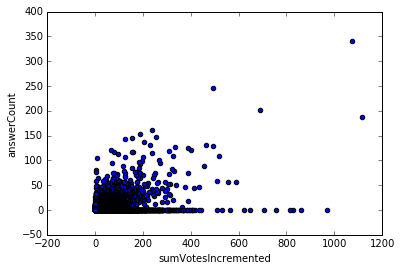

In [50]:
result.plot(kind='scatter', x='sumVotesIncremented', y='answerCount')

In [9]:
# this was taking forever..
# result.plot(kind='bar', x='authorKaid', y='sumVotesIncremented')

In [9]:
median = result.sumVotesIncremented.median()

# Prepare data to concatenate questions and answers

In [68]:
replies = result[result['replyTo'].notnull()]
questions = result[result['replyTo'].isnull()]

In [65]:
replies = replies[['video','id','replyTo','label','content']]
questions = questions[['video','id','replyTo','label','content']]
questions.head()

,video,id,replyTo,label,content
0,adding-and-subtracting-the-same-thing-from-bot...,baf97918adcfa541a668b8141c932adadbdb63b2,NaN,True,I have a great 'why' question. Why is there a...
1834,the-beauty-of-algebra,b6a0a3eec44cf791bf8dc64f75278f293911ee72,NaN,False,How do I do fractions?
1025,the-beauty-of-algebra,03ae91f219a5ff2df4646bd7c9b6247896b0e7fe,NaN,True,Why is learning alegbra so important?
1835,the-beauty-of-algebra,99504c27f0bfdc90b095a836a3a0266e18e9ceab,NaN,False,Why is the history of algebra important?
1836,the-beauty-of-algebra,e8ade3a31cf42a329470de8ff40e1d1be10c8166,NaN,False,""" for any positive integer n,n! denotes the pr..."


In [69]:
merged = pd.merge(replies, questions, how='inner', left_on='replyTo', right_on='id',
         left_index=False, right_index=False, sort=True,
         suffixes=('_r', '_q'), copy=True, indicator=False)

In [76]:
for col in merged.columns:
  print col

video_r
content_q
content_r
hasVotes_r


In [71]:
merged = merged[['video_r','content_q','content_r','hasVotes_r']]
merged.head()

,video_r,content_q,content_r,hasVotes_r
0,evaluating-a-function-expression,"At 1:09, Is -2*7+-5 consiered to be equal to -...",yeah it is true,False
1,evaluating-a-function-expression,"At 1:09, Is -2*7+-5 consiered to be equal to -...","YES! since f(-6) = 7 and since g(1) = -5, then...",True
2,a-tour-through-ancient-rome-in-320-c-e,what exactly is the forum? and what is the Pan...,Forum Romanum (https://www.khanacademy.org/hum...,True
3,ss-searching-for-scholarships,any suggestions for single parentsup to trying...,yes. you should probably find courses on the w...,True
4,introduction-to-square-roots,is it Principle not Principal?,I think principal root comes from the second d...,True


## Make a sample dataset for hand scoring

In [74]:
sample = merged.sample(n=500)
sample.to_csv("../data/500sample.csv")

## Concatenate questions and answers

In [40]:
merged['content'] = merged["content_q"].map(str) + " " + merged["content_r"]
merged = merged[['label_r','content']]

merged.head()


,label_r,content
0,0,what would you do if you raises a power to a p...
1,0,How do we find the basis of ker(T) when ker(T)...
2,0,"At 1:09, Is -2*7+-5 consiered to be equal to -..."
3,0,"At 1:09, Is -2*7+-5 consiered to be equal to -..."
4,0,if you use the tangent to find the slope of a ...


## For the TensorFlow CNN

In [91]:
# make positive and negative data sets
# TOP RANKED, replies onlu
pos_data_train = result.loc[result['hasVotes'] == True]
# pos_data_train = pos_data_train[pos_data_train['replyTo'].notnull()]

neg_data_train = result.loc[result['hasVotes'] == False]
# neg_data_train = neg_data_train[neg_data_train['replyTo'].notnull()]

print len(neg_data_train)
print len(pos_data_train)

206064
206064


In [45]:
# make positive and negative data sets
# replies only
pos_data_train = pos_data_train[pos_data_train['replyTo'].notnull()]

neg_data_train = neg_data_train[neg_data_train['replyTo'].notnull()]

# If using concatenated questions and answers
# pos_data_train = merged.loc[merged['label_r'] == 1]
# neg_data_train = merged.loc[merged['label_r'] == 0]


print len(neg_data_train)
print len(pos_data_train)

117641
157242


In [110]:
pos_data_test = test_data.loc[test_data['hasVotes'] == True]
# pos_data_test = pos_data_test[pos_data_test['replyTo'].notnull()]

neg_data_test = test_data.loc[test_data['hasVotes'] == False]
# neg_data_test = neg_data_test[neg_data_test['replyTo'].notnull()]
print len(neg_data_test)
print len(pos_data_test)

1892
3108


In [80]:
print len( max([x.split(' ') for x in neg_data_test['content']], key=len) )
print len( max([x.split(' ') for x in pos_data_test['content']], key=len) )

476

In [92]:
print len(max([x.split(' ') for x in neg_data_train['content']], key=len))
print len(max([x.split(' ') for x in pos_data_train['content']], key=len))

2999
3439


In [93]:
## THERE ARE SOME VERY LONG stupid responses which make the max document length really big, and explode the id matrix. 

## limit the replies to N words. This removes entries like 100K swastika symbols.
# N = 1000
# P = 3000
# neg_data_train = neg_data_train[[(len(x.split(' ')) < N) for x in neg_data_train['content']]]
# pos_data_train = pos_data_train[[(len(x.split(' ')) < P) for x in pos_data_train['content']]]

## Truncate to 1000 characters
neg_data_train['content'] = neg_data_train['content'].str[:1000]
pos_data_train['content'] = pos_data_train['content'].str[:1000]
print len(max([x.split(' ') for x in neg_data_train['content']], key=len))
print len(max([x.split(' ') for x in pos_data_train['content']], key=len))
" ".join(max([x.split(' ') for x in pos_data_train['content']], key=len))

/Users/koza/ipykernel/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/koza/ipykernel/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


994
770


"1) First  change your answer to a fraction.\n2)Then your numerator drops into a division box. ex. 1\n                                                                                    -          _______\n                                                                                     2       2| 1\n3)You cannot do this problem without a decimal\n\n                                                                                        __ __________\n                                                                                     2|   1.0                        \n\n                                                                                        _0.5_ __________\n                                                                                     2|   1.0 \n                                                                                           0\n    4)you divide(Don't forget the decimal and keep)          -------- \n                                                     

In [94]:
pos_data_train.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/pos_data_train',
                      columns=['content'],
                      index=False)


neg_data_train.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/neg_data_train',
                      columns=['content'],
                      index=False)

<pre>
python train.py --positive_data_file data/pos_data_train --negative_data_file data/neg_data_train --dev_sample_percentage .005

<pre>

In [111]:
pos_data_test.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/pos_data_test',
                      columns=['content'],
                      index=False)


neg_data_test.to_csv('/Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/data/neg_data_test',
                      columns=['content'],
                      index=False)

In [112]:
len(neg_data_test)

1892

python eval.py --eval_train true --positive_data_file data/pos_data_test --negative_data_file data/neg_data_test --checkpoint_dir /Users/koza/Documents/UCBerkeley/266/FinalProject/w266_Project/cnn-text-classification-tf/runs/1481637188/checkpoints

# Results
### The best CNN model produced 63.5% accuracy on the dev set, with the following parameters:
<pre>
python train.py 
    --positive_data_file data/pos_data_train 
    --negative_data_file data/neg_data_train 
    --dev_sample_percentage .005

-----------------------------
Parameters:
-----------------------------

DROPOUT_KEEP_PROB=0.5
EMBEDDING_DIM=128
FILTER_SIZES=3,4,5
L2_REG_LAMBDA=0.0
NUM_EPOCHS=200
NUM_FILTERS=128

positive_examples: 248,241
negative_examples: 163,887

Max_document_length: 702

Vocabulary Size: 173,722
Train/Dev split: 410,068/2,060

</pre>

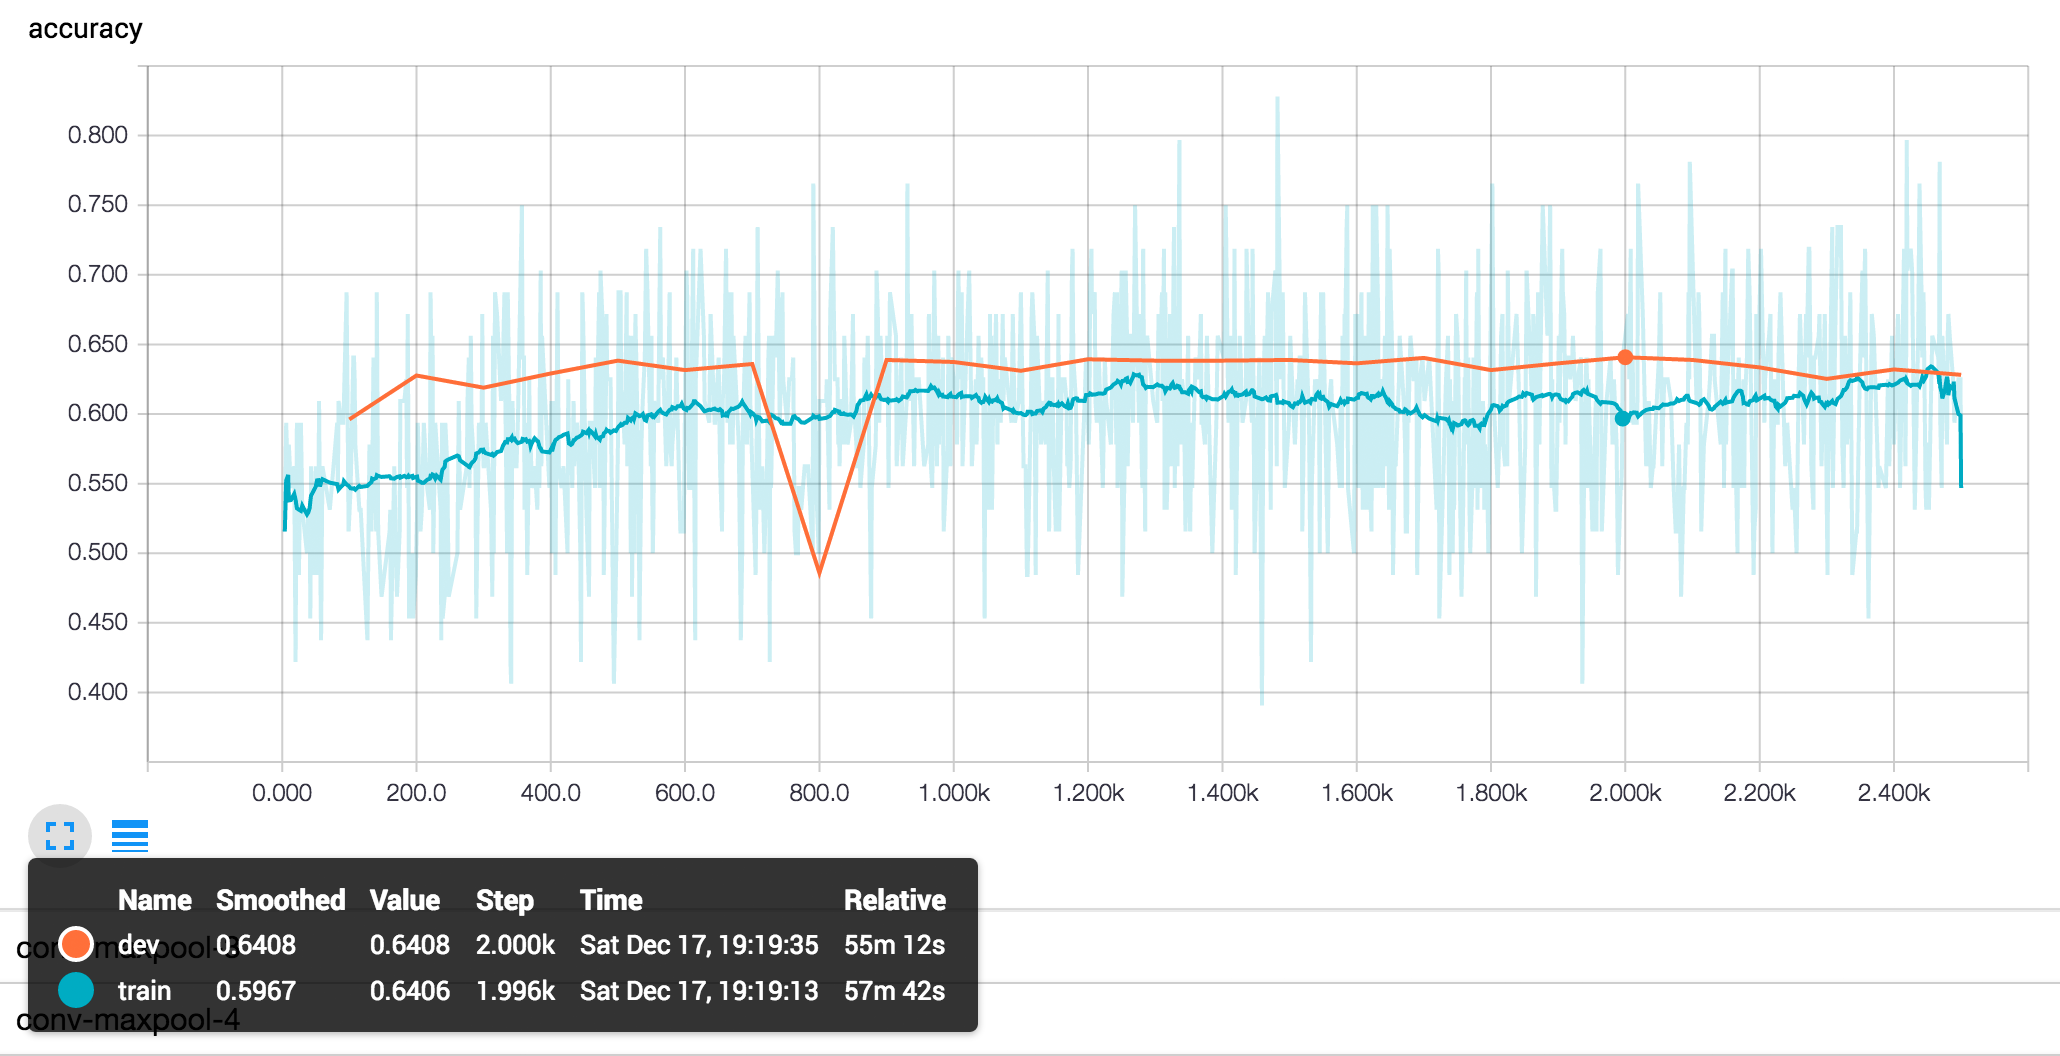

In [116]:
Image('CNN-results/best-CNN-accuracy.png')

# The CNN Graph:

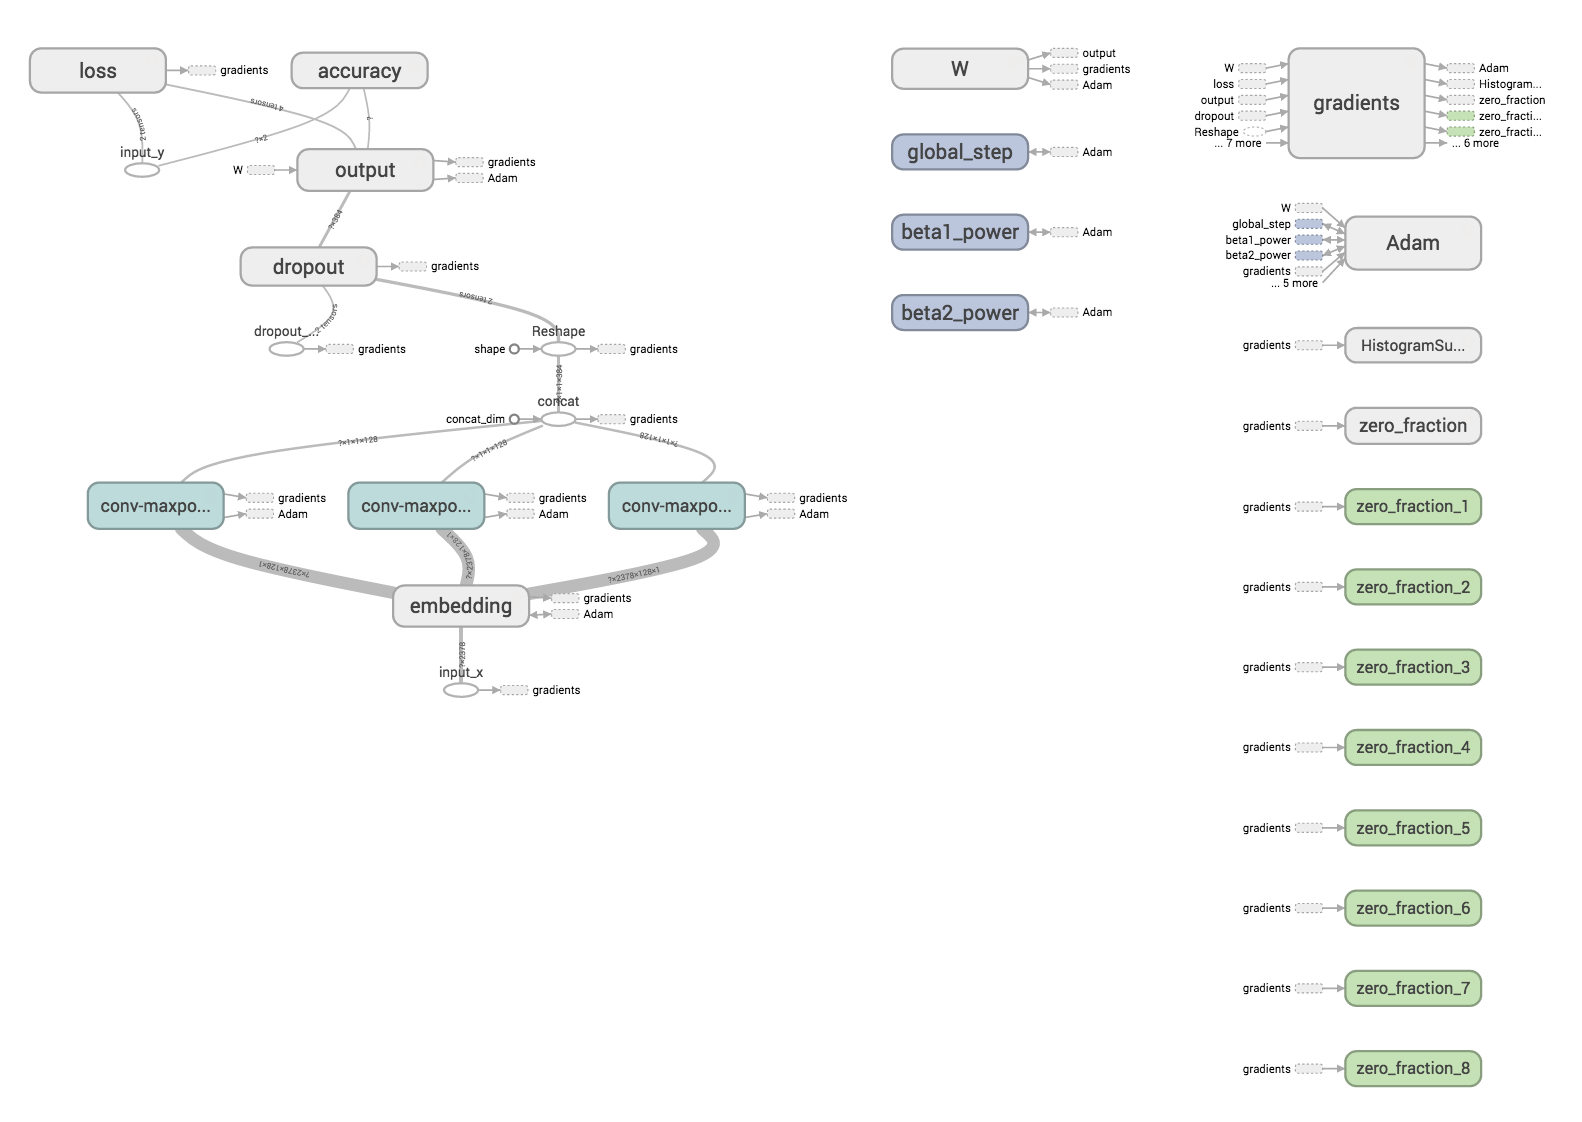

In [118]:
Image('CNN-results/graph.png')

## Test Runs (mini dataset)
The model was able to (mostly) memorize the tiny dataset:

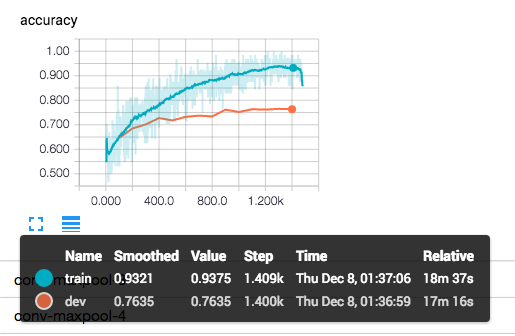

In [119]:
Image('images/CNN-using small dataset.png')

# Sources:
Theano and TensorFlow implementations used as boilerplate:

### Theano
http://arxiv.org/abs/1508.04112   
https://github.com/taolei87/text_convnet   

### TensorFlow
https://arxiv.org/pdf/1510.03820v4.pdf   
https://arxiv.org/pdf/1408.5882v2.pdf   
https://github.com/dennybritz/cnn-text-classification-tf   
http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/